# Introduction
In the previous notebook we predicted the next character of a name only by looking at the previous character. Here we want to do something in a bit more sophistcated way, as we want to use more of the context than a single character, and we will be doing it in different ways: bag-of-words and using a multilayer perceptron (MLP). The MLP approach will be based on the a [paper from 2003](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbGJ0RndnaG1JbUhHVURROWVQVFNuOWZwU01oQXxBQ3Jtc0ttbW5SQnhQN0ZMWWtHem5FVFA5dFFCdk02R29raDVBNlMxaXpxU3E1S2dReHAxcVRYQjN3bjZsM2ZLcjdkRG5oWTBnSU1OUjZsaThxSnZLdVpKWEFWTDgzZnd3QlNmQXRldFFxRjZ1ekdfUFV0ZnVTcw&q=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume3%2Fbengio03a%2Fbengio03a.pdf&v=TCH_1BHY58I), in which they predict the next word using the previous words.

We will be doing the following:

* TBD

# Libraries

In [80]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [81]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data
For creating the language models we use a dataset of the most common names from [ssa.gov](https://www.ssa.gov/oact/babynames/).

### Reading Data

In [82]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary
As a neural network works with numbers, we need a way to translate back and forth between letters and numbers.

In [83]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Preparing Dataset
For each letter we will be using the previous X characters to predict it (block_size). 

Example for emma:  

<pre>
... ---> e  
..e ---> m  
.em ---> m  
emm ---> a  
mma ---> .  
</pre>

In [84]:
block_size = 3
verbose = False

X, Y = [], []
for name in names:
    if verbose:
        print(name)
    context = [0] * block_size
    for char in name + '.':
        idx = chr_to_idx[char]
        X.append(context)
        Y.append(idx)
        if verbose:
            print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
        context = context[1:] + [idx]

In [85]:
# Printing example x and y
x2 = X[2]; print(''.join(idx_to_chr[x] for x in x2))
y2 = Y[2]; print(idx_to_chr[y2])

.em
m


In [86]:
# Converting lists to pytorch arrays
X = torch.tensor(X) # n_examples x block_size
Y = torch.tensor(Y) # n_examples

In [87]:
# Number of samples not to run out of memory
n_samples = len(Y)
X = X[:n_samples]
Y = Y[:n_samples]

# Building the Neural Network
We now build the neural network as described in the paper.

### The Lookup Table

First we build an embedding lookup table. The lookup table is in concept similar to that of the one-hot encodings, as we in both cases represent the individual characters as vectors. One-hot vectors are the same length as the vocabulary, while embedding vectors can be arbitrarily short, depending on how much information you want them to be able to store.

One-Hot Example with dictionary ABCD:
<pre>
  A B C D
A 1 0 0 0
B 0 1 0 0
B 0 1 0 0
A 1 0 0 0
</pre>

Lookup table Example with two dimenstions:
<pre>
Lookup table:
    d1    d2
A  0.1  -0.3
B -0.5  -0.7
C -0.1   1.3
D  3.0   0.9

Chars   Indicies     Embeddings
ABBA -> [1,2,2,1] -> [[0.1, -0.3],[-0.5, -0.7],[-0.5, -0.7],[0.1, -0.3]]
</pre>

In [9]:
# Building a lookup table (vocab_length x n_dimensions)
C = torch.randn([27, 2]); print(C)

tensor([[ 0.9934,  0.9937],
        [ 0.9063,  0.1049],
        [ 1.3440,  0.2482],
        [-0.1903,  0.3603],
        [ 0.3461, -0.0322],
        [ 0.5782, -0.1122],
        [-1.1620,  0.9323],
        [ 1.7361, -0.1493],
        [ 1.4606, -0.7879],
        [-0.2157, -0.1100],
        [ 0.3744,  0.2926],
        [ 1.6140, -0.6878],
        [ 1.7642,  0.5494],
        [-1.3256,  1.5837],
        [-0.1922,  0.0492],
        [ 0.6667, -0.2482],
        [-0.8593, -1.0975],
        [-0.1792, -1.1473],
        [ 0.0251,  0.0327],
        [-0.1805, -0.6411],
        [ 1.4852, -0.3194],
        [ 1.4910,  0.5114],
        [-2.3314, -1.7684],
        [ 0.3082,  0.7290],
        [ 1.6891, -1.2260],
        [-0.0223,  1.6806],
        [-1.1237,  0.1080]])


In [10]:
# Looking up the embedding of one character
chr = "c"; print(f"Character: {chr}")
idx = chr_to_idx[chr]; print(f"Vocab Index: {idx}")
embedding = C[idx]; print(f"Embedding: {embedding}")

Character: c
Vocab Index: 3
Embedding: tensor([-0.1903,  0.3603])


In [11]:
# Looking up embeddings of four characters: "abba"
chars = torch.tensor([1,2,2,1])
embeddings = C[chars]; embeddings

tensor([[0.9063, 0.1049],
        [1.3440, 0.2482],
        [1.3440, 0.2482],
        [0.9063, 0.1049]])

It is also possible to make these lookups in higher dimensionality, e.g. in our X-data we created earlier we have two dimensions, rows (samples) and columns (context window). Here we will try to look all X data up in the C lookup table.

In [12]:
# Dimensions are: n_samples x context_window x embedding_size
C[X]

tensor([[[ 0.9934,  0.9937],
         [ 0.9934,  0.9937],
         [ 0.9934,  0.9937]],

        [[ 0.9934,  0.9937],
         [ 0.9934,  0.9937],
         [ 0.5782, -0.1122]],

        [[ 0.9934,  0.9937],
         [ 0.5782, -0.1122],
         [-1.3256,  1.5837]],

        ...,

        [[ 0.6667, -0.2482],
         [ 1.7642,  0.5494],
         [ 0.5782, -0.1122]],

        [[ 1.7642,  0.5494],
         [ 0.5782, -0.1122],
         [-0.2157, -0.1100]],

        [[ 0.5782, -0.1122],
         [-0.2157, -0.1100],
         [ 1.7642,  0.5494]]])

These were all examples, so what we bring from this section into the next part of the neural network is the **lookup table** as well as the **embeddings**.

In [13]:
# Lookup table: vocab_size x embedding_dimension
C = torch.randn([27, 2])

# Embeddings
emb = C[X]

### Adding more layers to the network
The different layers of the network fit together via their input- and output-dimensions. 

Examples of dimensions:  

* samples: n_samples x context_window  
* lookup table: vocab_size x embedding_size  
* layer: (context_window * embedding_size) x n_neurons  

After the samples have gone through the embedding layer we have a matrix pr sample of dimension context_window x embedding_size. Before we can multiply this output with the first neuron layer, we need to unstack it:

<pre>
[[1,2],
 [4,5],    ---> [1,2,3,4,5,6]
 [6,7]]
</pre>

Actually pytorch stores its data as a one-dimentional tensor all ready, and one can easily alter between the dimensionality using .view(). We will use that here to unstack the two dimensions.

In [14]:
# Weights and biases (layer 1)
W1 = torch.randn([6,100])
b1 = torch.randn([100])

In [15]:
# Unstack example
e1 = torch.arange(18); print(e1)
e2 = e1.view(3,3,2); print(e2)
e3 = e2.view(3,6); print(e3)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17]])


In [16]:
# Unstacking sample dimensions and calculating activations
h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()

torch.Size([10000, 100])

In [17]:
# Weights and biases (layer 2)
W2 = torch.randn([100,27])
b2 = torch.randn([27])

In [18]:
# Calculating logits for each possible output
logits = h @ W2 + b2; logits.shape

torch.Size([10000, 27])

In [19]:
# Calculating probablitities pr character pr sample
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True); probs.size()

torch.Size([10000, 27])

In [ ]:
## Calculating loss
### Without regularization
### loss = -probs[:,ys[:n_samples]].log().mean()
### With regulatization (Rewarding low Ws)
loss = -probs[:,Y].log().mean()

Now we write it all into a few cells removing all the example code.

In [26]:
# Lookup table
C = torch.randn([27, 2])

# Weights and biases
W1 = torch.randn([6,100])
b1 = torch.randn([100])
W2 = torch.randn([100,27])
b2 = torch.randn([27])
print("Number of parameters: " + str(sum(p.nelement() for p in [C, W1, b1, W2, b2])))

Number of parameters: 3481


In [27]:
# Forward pass
emb = C[X]
h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True); probs.size()
loss = -probs[:,Y].log().mean()
loss

tensor(14.6651)

### Simplifying and Training Model
All the places we can use the pytorch native metods we want to do that, e.g. pytorch can calculate the cross entropy loss for us instead of us doing it explicitely. Pytorch uses less memory, is more efficient and is better at handling extreme numbers. After simplifying we will write the code into a training loop.

In [101]:
# Hyperparameters
epochs = 1000
lr = 0.1

In [102]:
# Lookup table
C = torch.randn([27, 2])

# Weights and biases
W1 = torch.randn([6,100])
b1 = torch.randn([100])
W2 = torch.randn([100,27])
b2 = torch.randn([27])

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 3481


In [69]:
for _ in range(epochs):
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y);print(loss)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    for p in parameters:
        p.data += -lr * p.grad

tensor(14.0372, grad_fn=<NllLossBackward0>)
tensor(13.2221, grad_fn=<NllLossBackward0>)
tensor(12.4874, grad_fn=<NllLossBackward0>)
tensor(11.8202, grad_fn=<NllLossBackward0>)
tensor(11.2219, grad_fn=<NllLossBackward0>)
tensor(10.6884, grad_fn=<NllLossBackward0>)
tensor(10.2120, grad_fn=<NllLossBackward0>)
tensor(9.7789, grad_fn=<NllLossBackward0>)
tensor(9.3854, grad_fn=<NllLossBackward0>)
tensor(9.0160, grad_fn=<NllLossBackward0>)
tensor(8.6726, grad_fn=<NllLossBackward0>)
tensor(8.3471, grad_fn=<NllLossBackward0>)
tensor(8.0378, grad_fn=<NllLossBackward0>)
tensor(7.7447, grad_fn=<NllLossBackward0>)
tensor(7.4682, grad_fn=<NllLossBackward0>)
tensor(7.2084, grad_fn=<NllLossBackward0>)
tensor(6.9651, grad_fn=<NllLossBackward0>)
tensor(6.7386, grad_fn=<NllLossBackward0>)
tensor(6.5290, grad_fn=<NllLossBackward0>)
tensor(6.3364, grad_fn=<NllLossBackward0>)
tensor(6.1601, grad_fn=<NllLossBackward0>)
tensor(5.9988, grad_fn=<NllLossBackward0>)
tensor(5.8508, grad_fn=<NllLossBackward0>)
tens

KeyboardInterrupt: 

### Mini-batching
It can be quite heavy to process all the data in every forward/backward pass, which it why people often divided their data into mini-batches. This simply means to take a random group of data points for each epoch. This is introduced in this next training loop.

In [94]:
for _ in range(epochs):
    # Minibatch (32 random sample indices/integers)
    ix = torch.randint(0, X.shape[0], (minibatch_size,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]);print(loss)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    for p in parameters:
        p.data += -lr * p.grad

tensor(3.4290, grad_fn=<NllLossBackward0>)
tensor(2.9174, grad_fn=<NllLossBackward0>)
tensor(4.0238, grad_fn=<NllLossBackward0>)
tensor(2.9081, grad_fn=<NllLossBackward0>)
tensor(3.7875, grad_fn=<NllLossBackward0>)
tensor(3.6535, grad_fn=<NllLossBackward0>)
tensor(3.9753, grad_fn=<NllLossBackward0>)
tensor(3.2557, grad_fn=<NllLossBackward0>)
tensor(3.9341, grad_fn=<NllLossBackward0>)
tensor(3.4877, grad_fn=<NllLossBackward0>)
tensor(4.2231, grad_fn=<NllLossBackward0>)
tensor(3.5120, grad_fn=<NllLossBackward0>)
tensor(3.6659, grad_fn=<NllLossBackward0>)
tensor(3.6056, grad_fn=<NllLossBackward0>)
tensor(3.1839, grad_fn=<NllLossBackward0>)
tensor(3.3037, grad_fn=<NllLossBackward0>)
tensor(3.9968, grad_fn=<NllLossBackward0>)
tensor(5.4329, grad_fn=<NllLossBackward0>)
tensor(3.0068, grad_fn=<NllLossBackward0>)
tensor(3.8966, grad_fn=<NllLossBackward0>)
tensor(3.3771, grad_fn=<NllLossBackward0>)
tensor(3.3561, grad_fn=<NllLossBackward0>)
tensor(3.4767, grad_fn=<NllLossBackward0>)
tensor(4.37

tensor(2.9965, grad_fn=<NllLossBackward0>)
tensor(2.7126, grad_fn=<NllLossBackward0>)
tensor(2.8067, grad_fn=<NllLossBackward0>)
tensor(2.8621, grad_fn=<NllLossBackward0>)
tensor(3.0550, grad_fn=<NllLossBackward0>)
tensor(2.8339, grad_fn=<NllLossBackward0>)
tensor(2.7108, grad_fn=<NllLossBackward0>)
tensor(2.6854, grad_fn=<NllLossBackward0>)
tensor(2.9681, grad_fn=<NllLossBackward0>)
tensor(2.8135, grad_fn=<NllLossBackward0>)
tensor(2.4928, grad_fn=<NllLossBackward0>)
tensor(2.6531, grad_fn=<NllLossBackward0>)
tensor(2.6595, grad_fn=<NllLossBackward0>)
tensor(2.8256, grad_fn=<NllLossBackward0>)
tensor(2.7970, grad_fn=<NllLossBackward0>)
tensor(3.4772, grad_fn=<NllLossBackward0>)
tensor(2.7976, grad_fn=<NllLossBackward0>)
tensor(3.0324, grad_fn=<NllLossBackward0>)
tensor(2.6248, grad_fn=<NllLossBackward0>)
tensor(2.8716, grad_fn=<NllLossBackward0>)
tensor(2.7970, grad_fn=<NllLossBackward0>)
tensor(2.7360, grad_fn=<NllLossBackward0>)
tensor(3.2900, grad_fn=<NllLossBackward0>)
tensor(2.83

tensor(3.1492, grad_fn=<NllLossBackward0>)
tensor(2.7497, grad_fn=<NllLossBackward0>)
tensor(2.7147, grad_fn=<NllLossBackward0>)
tensor(2.7513, grad_fn=<NllLossBackward0>)
tensor(2.6705, grad_fn=<NllLossBackward0>)
tensor(3.0630, grad_fn=<NllLossBackward0>)
tensor(2.8952, grad_fn=<NllLossBackward0>)
tensor(2.7970, grad_fn=<NllLossBackward0>)
tensor(2.6445, grad_fn=<NllLossBackward0>)
tensor(2.9208, grad_fn=<NllLossBackward0>)
tensor(2.7264, grad_fn=<NllLossBackward0>)
tensor(2.4717, grad_fn=<NllLossBackward0>)
tensor(2.8679, grad_fn=<NllLossBackward0>)
tensor(2.6281, grad_fn=<NllLossBackward0>)
tensor(2.8221, grad_fn=<NllLossBackward0>)
tensor(2.5545, grad_fn=<NllLossBackward0>)
tensor(2.6951, grad_fn=<NllLossBackward0>)
tensor(2.3789, grad_fn=<NllLossBackward0>)
tensor(2.4508, grad_fn=<NllLossBackward0>)
tensor(3.3830, grad_fn=<NllLossBackward0>)
tensor(3.1347, grad_fn=<NllLossBackward0>)
tensor(2.2739, grad_fn=<NllLossBackward0>)
tensor(2.4202, grad_fn=<NllLossBackward0>)
tensor(2.23

In [96]:
# Full loss
emb = C[X]
h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y);print(loss)

tensor(2.6426, grad_fn=<NllLossBackward0>)


The gradient with minibatches will be much less stable/precise than with all the data, but it is still better to use minibatches with many epochs than to run few epochs with all the data.

### What is a resonable learning rate?
Here we will try to identify the best learning rate by searching over a bunch of learning rates.

In [99]:
# Learning rate exponent candidates
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre; print(lrs[:3]); print(lrs[-3:])

tensor([0.0010, 0.0010, 0.0010])
tensor([0.9863, 0.9931, 1.0000])


In [105]:
# Testing learning rates
lri = []
lossi = []
for i in range(1000):
    # Minibatch (32 random sample indices/integers)
    ix = torch.randint(0, X.shape[0], (minibatch_size,))
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.size()[0], emb.size()[1]*emb.size()[2]) @ W1 + b1); h.size()
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # Tracking stats
    lri.append(lr)
    lossi.append(loss.item())

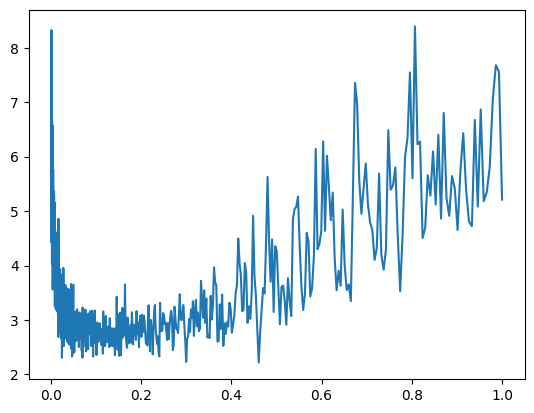

In [106]:
# Plotting learning rates vs losses
plt.plot(lri, lossi)

Now we can see that the best learning rate is the best when it is around 0.01. It is, however, just a rought estimate, and it likely that the learning rate should e.g. vary between layers, and between iterations. E.g. for the last few iterations one would use a lower learning rate (learning rate decay). This will, however, not be covered here.

In [ ]:
# Continue: http://www.youtube.com/watch?v=TCH_1BHY58I&t=52m20s